In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import sys
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 200

In [2]:
x = pd.read_csv("./data/winemag-data_first150k.csv")

In [3]:
x.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


No rows with empty country, province, variety, and winery

no location info:
- @suskostrzewa
- @kerinokeefe
- @vossroger
- @wineschach


can't find handle:
- @winechristina

In [4]:
# get lat long of countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [5]:
latlong = world.centroid
latlong = pd.concat([world.name, latlong.x, latlong.y], axis=1)
latlong = latlong.rename(columns={'name' :'country', 0 : 'long', 1 : 'lat'})
latlong = latlong[['country', 'lat', 'long']] # reorder to (lat,long)
latlong.head()

,country,lat,long
0,Fiji,-17.316309,163.853165
1,Tanzania,-6.257732,34.752990
2,W. Sahara,24.291173,-12.137831
3,Canada,61.469076,-98.142381
4,United States of America,45.705628,-112.599436


## Remove rows with missing country value

In [6]:
x = x[~pd.isnull(x.country)]

In [7]:
# replace names to match those on centroid list
x.country = x.country.replace(['US', 'Czech Republic', 'England'], ['United States of America', 'Czechia', 'United Kingdom'])

# remove arbitrary countries
x = x.drop(x[(x['country']=='US-France') | (x['country']=='Bosnia and Herzegovina')].index)

## should give us total of 46 countries

In [8]:
unique_countries = sorted(list(set(x['country'])))
print('There are %d different countries in the wine reviews dataset:\n' % len(unique_countries))
print(', '.join(sorted(unique_countries)))

There are 46 different countries in the wine reviews dataset:

Albania, Argentina, Australia, Austria, Brazil, Bulgaria, Canada, Chile, China, Croatia, Cyprus, Czechia, Egypt, France, Georgia, Germany, Greece, Hungary, India, Israel, Italy, Japan, Lebanon, Lithuania, Luxembourg, Macedonia, Mexico, Moldova, Montenegro, Morocco, New Zealand, Portugal, Romania, Serbia, Slovakia, Slovenia, South Africa, South Korea, Spain, Switzerland, Tunisia, Turkey, Ukraine, United Kingdom, United States of America, Uruguay


In [9]:
np.unique(x[x['country']=='United States of America']['province'], return_counts=True)

(array(['America', 'Arizona', 'California', 'Colorado', 'Connecticut',
        'Idaho', 'Iowa', 'Kentucky', 'Massachusetts', 'Michigan',
        'Missouri', 'Nevada', 'New Jersey', 'New Mexico', 'New York',
        'North Carolina', 'Ohio', 'Oregon', 'Pennsylvania', 'Texas',
        'Vermont', 'Virginia', 'Washington', 'Washington-Oregon'],
       dtype=object),
 array([   27,    39, 44508,    30,     2,   136,     4,     4,    10,
           25,    60,     1,    24,    95,  2428,    20,    34,  4589,
           50,    41,     2,   515,  9750,     3]))

In [49]:
def find_latlong(countries):
    lat = []
    long = []
    for country in countries:
        row = latlong[latlong['country'] == country]
        lat.append(float(row.lat))
        long.append(float(row.long))
    
    return lat,long

lat, long = find_latlong(unique_countries)

In [50]:
def find_review_freq(countries):
    freq = []
    for country in countries:
        row = x[x['country']==country]
        freq.append(row.country.count())
    
    return freq

freq = find_review_freq(unique_countries)

In [51]:
def find_review_avgs(countries):
    avg_points = []
    avg_prices = []
    for country in countries:
        row = x[x['country'] == country]
        avg_points.append(row.points.mean())
        avg_prices.append(row.price.mean())
        
    return avg_points, avg_prices

avg_points, avg_prices = find_review_avgs(unique_countries)

# Simple data exploration and visualization

### Review quantity

Text(0.5, 1.0, 'Top 10 wine producing countries')

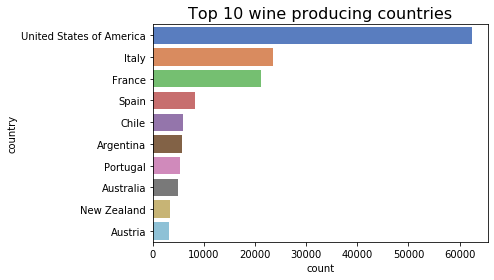

In [35]:
sns.countplot(y='country', data=x, order=x.country.value_counts().iloc[:10].index, palette='muted')
plt.title('Top 10 wine producing countries', fontsize=16)

In [45]:
# probability distribution
x['country'].value_counts() / len(x)

United States of America    0.413444
Italy                       0.155566
France                      0.139796
Spain                       0.054784
Chile                       0.038537
Argentina                   0.037311
Portugal                    0.035264
Australia                   0.032845
New Zealand                 0.021998
Austria                     0.020256
Germany                     0.016247
South Africa                0.014962
Greece                      0.005857
Israel                      0.004174
Hungary                     0.001531
Canada                      0.001299
Romania                     0.000921
Slovenia                    0.000623
Uruguay                     0.000610
Croatia                     0.000590
Bulgaria                    0.000510
Moldova                     0.000470
Mexico                      0.000417
Turkey                      0.000345
Georgia                     0.000285
Lebanon                     0.000245
Cyprus                      0.000205
B

In [43]:
# sum of top 10 countries
np.sum((x['country'].value_counts())[:10])

143344

In [47]:
# total # of countries
len(x['country'].value_counts())

46

> The top 10 countries make up 143,344 reviews which accounts for 95% of all reviews. There are 46 total countries in the dataset.
>
> The US has the most wine reviews in this dataset with 62397 reviews (41.34%). Not surprising since the dataset is from WineEnthusiast, a NY-based company. Following the US are Italy (15.56%), France (13.98%), Spain (5.48%), and Chile (3.85%).

### Review quality

Text(0.5, 1.0, 'Points distribution')

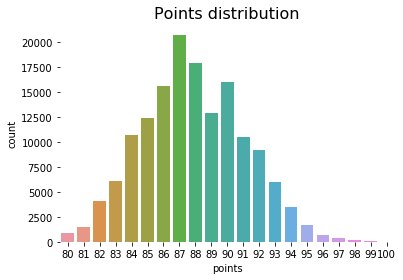

In [11]:
sns.countplot(x['points'])
sns.despine(bottom=True, left=True)
plt.title('Points distribution', fontsize=16)

In [48]:
x['points'].describe()

count    150920.000000
mean         87.888610
std           3.222285
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

> Points are distributed with minimum 80, max 100, and average ~88 points. 

In [151]:
qualitydf = x.groupby('country').agg('mean').sort_values(by='points', ascending=False).head(10)
qualitydf['country'] = qualitydf.index

Text(0.5, 1.0, 'Top 10 average wine point countries')

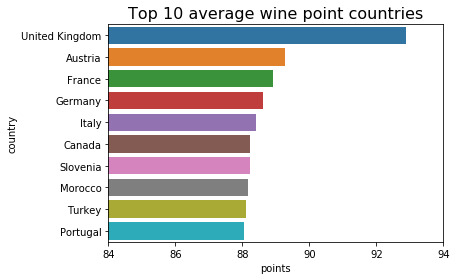

In [147]:
qualitybar = sns.barplot(y='country', x='points', data=qualitydf)
qualitybar.set_xlim(84,94)
plt.title('Top 10 average wine point countries', fontsize=16)

In [154]:
x.country.value_counts()

United States of America    62397
Italy                       23478
France                      21098
Spain                        8268
Chile                        5816
Argentina                    5631
Portugal                     5322
Australia                    4957
New Zealand                  3320
Austria                      3057
Germany                      2452
South Africa                 2258
Greece                        884
Israel                        630
Hungary                       231
Canada                        196
Romania                       139
Slovenia                       94
Uruguay                        92
Croatia                        89
Bulgaria                       77
Moldova                        71
Mexico                         63
Turkey                         52
Georgia                        43
Lebanon                        37
Cyprus                         31
Brazil                         25
Macedonia                      16
Serbia        

> Surprisingly, the UK leads the list when it comes to wine review points with an average of 92.89%. Interesting to see that the US did not make the top 10. Looking back at the frequency data, the UK only has 9 reviews which is far too little compared to 62397 of the US. Our data is skewed and this isn't quite the fairest comparison. 

<Figure size 360x504 with 0 Axes>

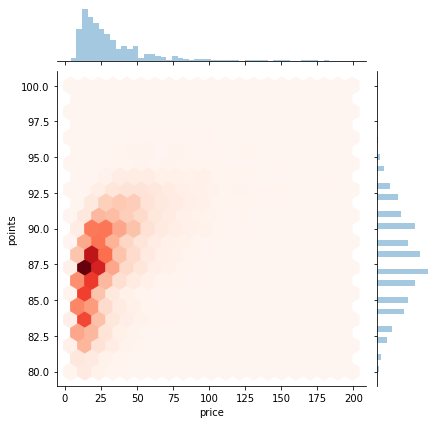

In [155]:
# sns.reset_orig()
# sns.set()
plt.figure(figsize=(5,7))
sns.jointplot(x='price', y='points', data=x[x['price'] < 200], kind='hex', gridsize=20, cmap='Reds')
# sns.despine(bottom=False, left=True)
# plt.title('points vs prices', y=0.5, fontsize=16)

> Average price around $20 and average points around 88.

In [17]:
print("countries missing prices:")
print(unique_countries[12])
print(unique_countries[40])

countries missing prices:
Egypt
Tunisia


In [18]:
# write freq, points, prices aggregate csv

FILE = './wine-aggregate-loc.csv'

if not os.path.exists(FILE):
    with open(FILE, 'w+') as file:
        file.write('country,lat,long,freq,points,prices\n')
        for country,la,lo,f,po,pr in zip(unique_countries, lat, long, freq, avg_points, avg_prices):
            tmp = ",".join([country,str(la),str(lo),str(f),str(po),str(pr)])
            file.write(tmp + '\n')
        file.close()
        
# for country,la,lo,f in zip(unique_countries, lat, long, freq):
#     print(",".join([country,str(la),str(lo),str(f)]))

In [19]:
# write freq as csv

FILE = './wine-freq-loc.csv'

if not os.path.exists(FILE):
    with open(FILE, 'w+') as file:
        file.write('country,lat,long,freq\n')
        for country,la,lo,f in zip(unique_countries, lat, long, freq):
            tmp = ",".join([country,str(la),str(lo),str(f)])
            file.write(tmp + '\n')
        file.close()
        
# for country,la,lo,f in zip(unique_countries, lat, long, freq):
#     print(",".join([country,str(la),str(lo),str(f)]))

In [20]:
# write avg points as csv

FILE = './wine-points-loc.csv'

if not os.path.exists(FILE):
    with open(FILE, 'w+') as file:
        file.write('country,lat,long,points\n')
        for country,la,lo,f in zip(unique_countries, lat, long, avg_points):
            tmp = ",".join([country,str(la),str(lo),str(f)])
            file.write(tmp + '\n')
        file.close()
        
# for country,la,lo,f in zip(unique_countries, lat, long, freq):
#     print(",".join([country,str(la),str(lo),str(f)]))

In [21]:
# write freq as csv

FILE = './wine-price-loc.csv'

if not os.path.exists(FILE):
    with open(FILE, 'w+') as file:
        file.write('country,lat,long,prices\n')
        for country,la,lo,f in zip(unique_countries, lat, long, avg_prices):
            if f==f: # check for nans
                tmp = ",".join([country,str(la),str(lo),str(f)])
                file.write(tmp + '\n')
        file.close()
        
# for country,la,lo,f in zip(unique_countries, lat, long, freq):
#     print(",".join([country,str(la),str(lo),str(f)]))

In [22]:
np.min(freq)

2

In [23]:
map_freq = folium.Map(name='Map of wine review frequencies', location=[0,0], tiles='OpenStreetMap', zoom_start=1)

for country,la,lo,val in zip(unique_countries, lat, long, freq):
    folium.Circle(location=[la,lo], tooltip=('%s: %d' % (country,int(val))), radius=int(val)*25, color='crimson', fill=True, fill_color='crimson').add_to(map_freq)

In [24]:
map_freq

In [25]:
map_points = folium.Map(name='Map of aveage wine reviews', location=[0,0], tiles='OpenStreetMap', zoom_start=1)

for country,la,lo,val in zip(unique_countries, lat, long, avg_points):
    folium.Circle(location=[la,lo], tooltip=('%s: %d' % (country,int(val))), radius=int(val)*4000, color='crimson', fill=True, fill_color='crimson').add_to(map_points)

In [26]:
map_points

In [27]:
map_prices = folium.Map(name='Map of average wine prices', location=[0,0], tiles='OpenStreetMap', zoom_start=1)

for country,la,lo,val in zip(unique_countries, lat, long, avg_prices):
    if val==val:
        folium.Circle(location=[la,lo], tooltip=('%s: $%d' % (country,int(val))), radius=int(val)*5000, color='crimson', fill=True, fill_color='crimson').add_to(map_prices)

In [28]:
map_prices